# HSI exploration

## Library imports

### raster.io

In [2]:
import rasterio
from rasterio.windows import Window

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors

In [4]:
%matplotlib notebook

In [5]:
import numpy as np

## Loading the data

In [6]:
dataset_filename = '../DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif'
# dataset_filename = '/Users/vasilii.mosin/Desktop/HYPERSPECTRAL_DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif'

In [7]:
dataset = rasterio.open(dataset_filename)

In [8]:
bands = dataset.indexes[:-1]

In [9]:
print(f'The dataset {dataset.name} is a {dataset.width}x{dataset.height} image containing {len(bands)} bands.')

The dataset /Users/vasilii.mosin/Desktop/HYPERSPECTRAL_DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif is a 7784x7954 image containing 17 bands.


In [26]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint16',
 2: 'uint16',
 3: 'uint16',
 4: 'uint16',
 5: 'uint16',
 6: 'uint16',
 7: 'uint16',
 8: 'uint16',
 9: 'uint16',
 10: 'uint16',
 11: 'uint16',
 12: 'uint16',
 13: 'uint16',
 14: 'uint16',
 15: 'uint16',
 16: 'uint16',
 17: 'uint16',
 18: 'uint16'}

In [15]:
dataset.bounds

BoundingBox(left=45.4419705219378, bottom=61.42842706873281, right=45.485734695600044, top=61.449840180541)

In [16]:
dataset.crs

CRS({'init': 'epsg:4326'})

In [161]:
cm = matplotlib.colors.Colormap('inferno', N=256)
cm=plt.get_cmap('viridis')
cm.set_bad(color='k')

In [162]:
print(cm)

<IPython.core.display.Javascript object>


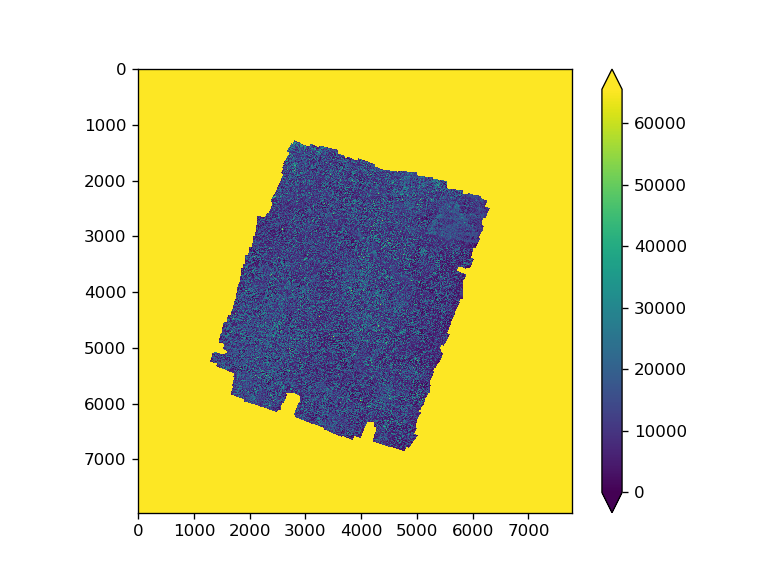

In [211]:
band1 = dataset.read(1)

plt.figure()
plt.imshow(band1,cmap=plt.cm.viridis)
plt.colorbar(extend='both')
#plt.clim(0, 50000);

### Dataset mask

The last channel (# 18) is the image mask that identifies regions of valid data values. 

<IPython.core.display.Javascript object>


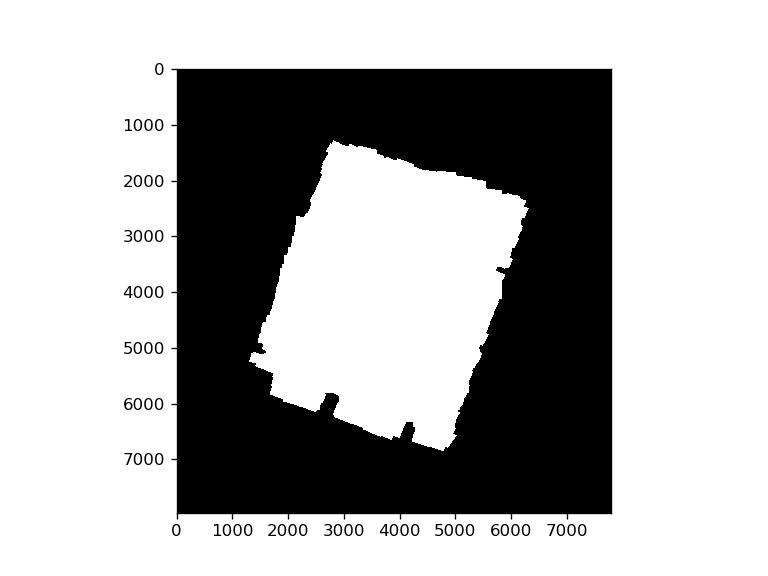

In [217]:
band16 = dataset.read(18)

plt.figure()
plt.imshow(band16,cmap=plt.cm.binary_r)

## One tree exploration

### Crop the image

In [255]:
with rasterio.open(dataset_filename) as src:
...     tree = src.read(src.indexes, window=Window(4680, 2890, 40, 40))[:-1]

<IPython.core.display.Javascript object>


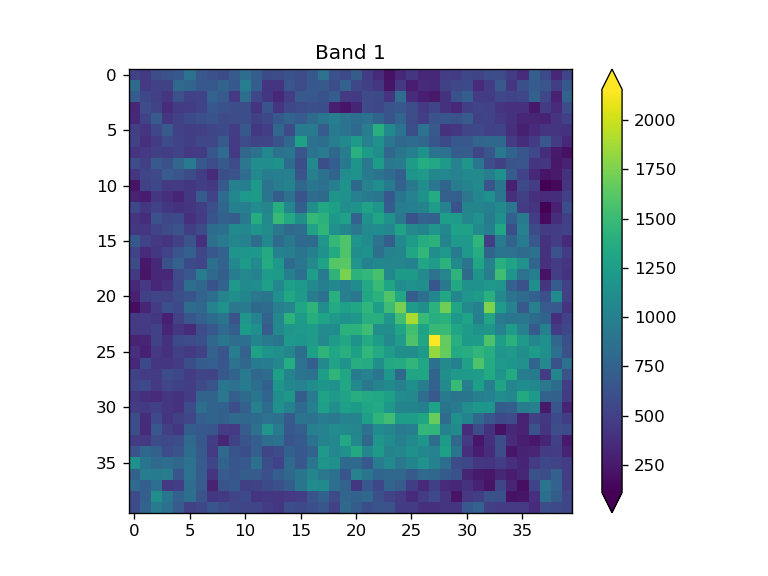

In [256]:
plt.figure()
plt.title(f'Band 1')
plt.imshow(tree[1])
plt.colorbar(extend='both')

### Features extraction

In [257]:
tree.shape

(17, 40, 40)

In [259]:
tree_p_b = tree.reshape(tree.shape[0],-1)
tree_p_b.shape

(17, 1600)

In [260]:
tree_avg = np.average(tree_p_b,axis=1)
tree_min = np.min(tree_p_b,axis=1)
tree_max = np.max(tree_p_b,axis=1)

<IPython.core.display.Javascript object>


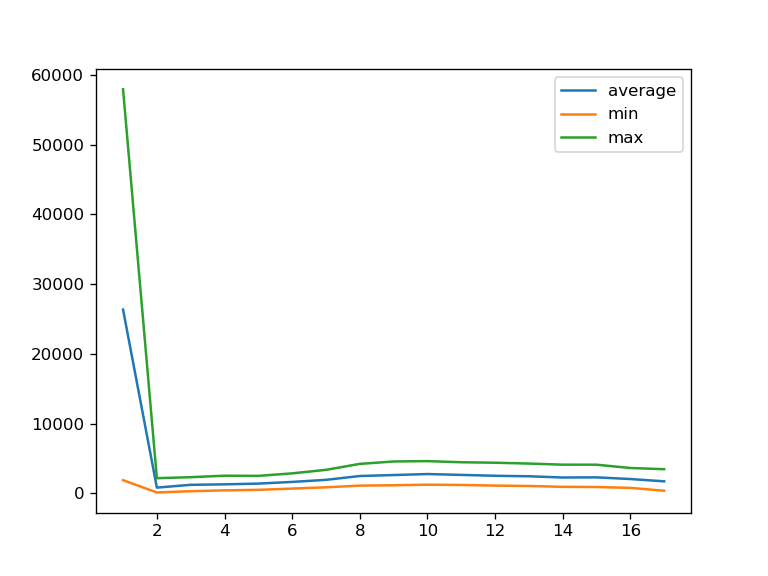

In [264]:
plt.figure()
plt.plot(bands,tree_avg, label = 'average')
plt.plot(bands,tree_min, label = 'min')
plt.plot(bands,tree_max, label = 'max')
plt.legend()

### Display all bands

<IPython.core.display.Javascript object>


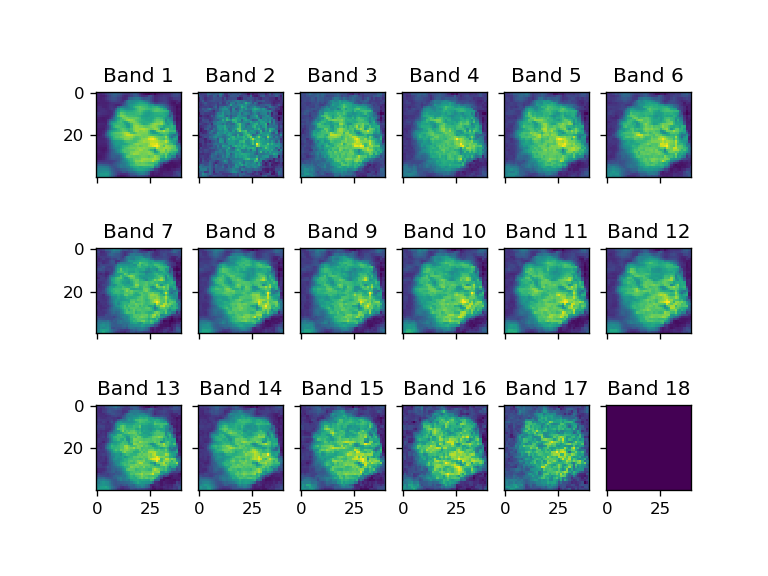

In [230]:
fig, axes = plt.subplots(3,6,sharex=True,sharey=True)
for i in range(len(dataset.indexes)):
    axes.flatten()[i].imshow(tree[i,:,:])
    axes.flatten()[i].set_title(f'Band {dataset.indexes[i]}')

### Animation

In [221]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)
    ax.set_title(f'Band {ax.index+1}')

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'Band {ax.index+1}')

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'Band {ax.index+1}')

<IPython.core.display.Javascript object>


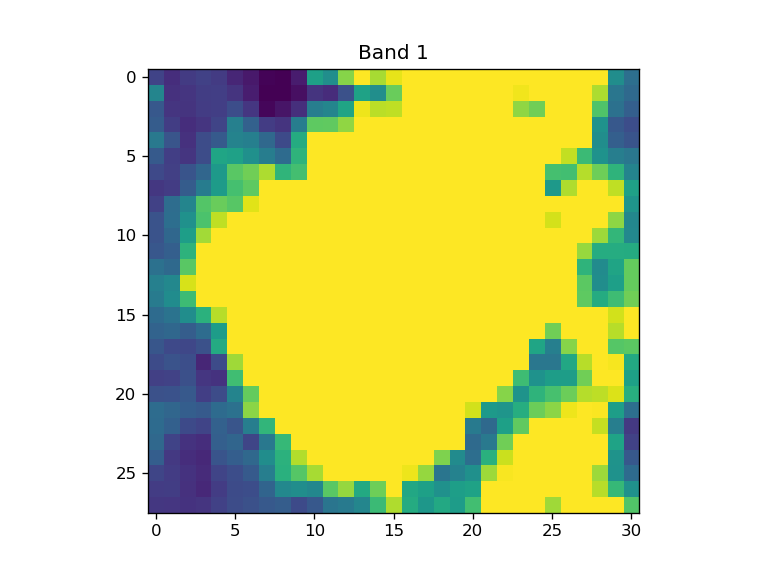

In [223]:
multi_slice_viewer(w[:17])

In [75]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


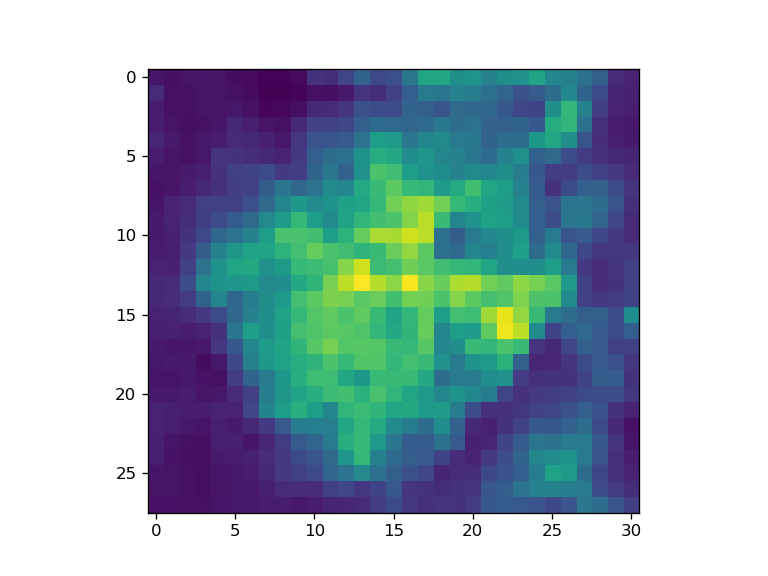

In [84]:

volume = w[:17]

fig = plt.figure()
im = plt.imshow(volume[0])
 
    
def animate(i):
    im.set_array(volume[i])
    im.set_norm()
    return im,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=18, interval=100, blit=False)
plt.show()

##  ITCD - Individual tree crown detection

In [10]:
from thresholding_watershed import itcd as itcd_tw
from local_maxima import itcd as itcd_lm
from skimage.color import gray2rgb

In [11]:
with rasterio.open(dataset_filename) as src:
...     trees = src.read(src.indexes, window=Window(3080, 2090, 200, 200))[:-1]

In [12]:
trees_mono = trees[7]

<IPython.core.display.Javascript object>


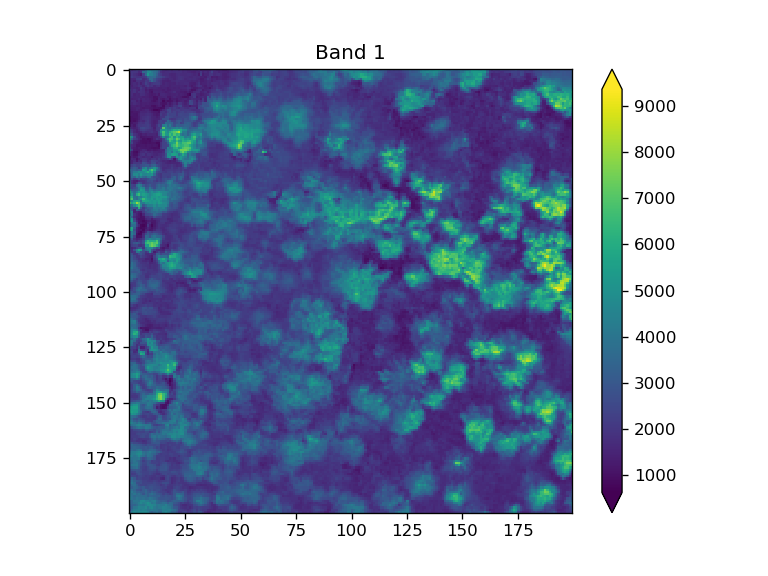

In [10]:
plt.figure()
plt.title(f'Band 1')
plt.imshow(trees_mono)
plt.colorbar(extend='both')

In [13]:
from skimage.exposure import rescale_intensity

### Watershed ITCD

In [14]:
i = 7

trees_mono = trees[i,:]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

<IPython.core.display.Javascript object>


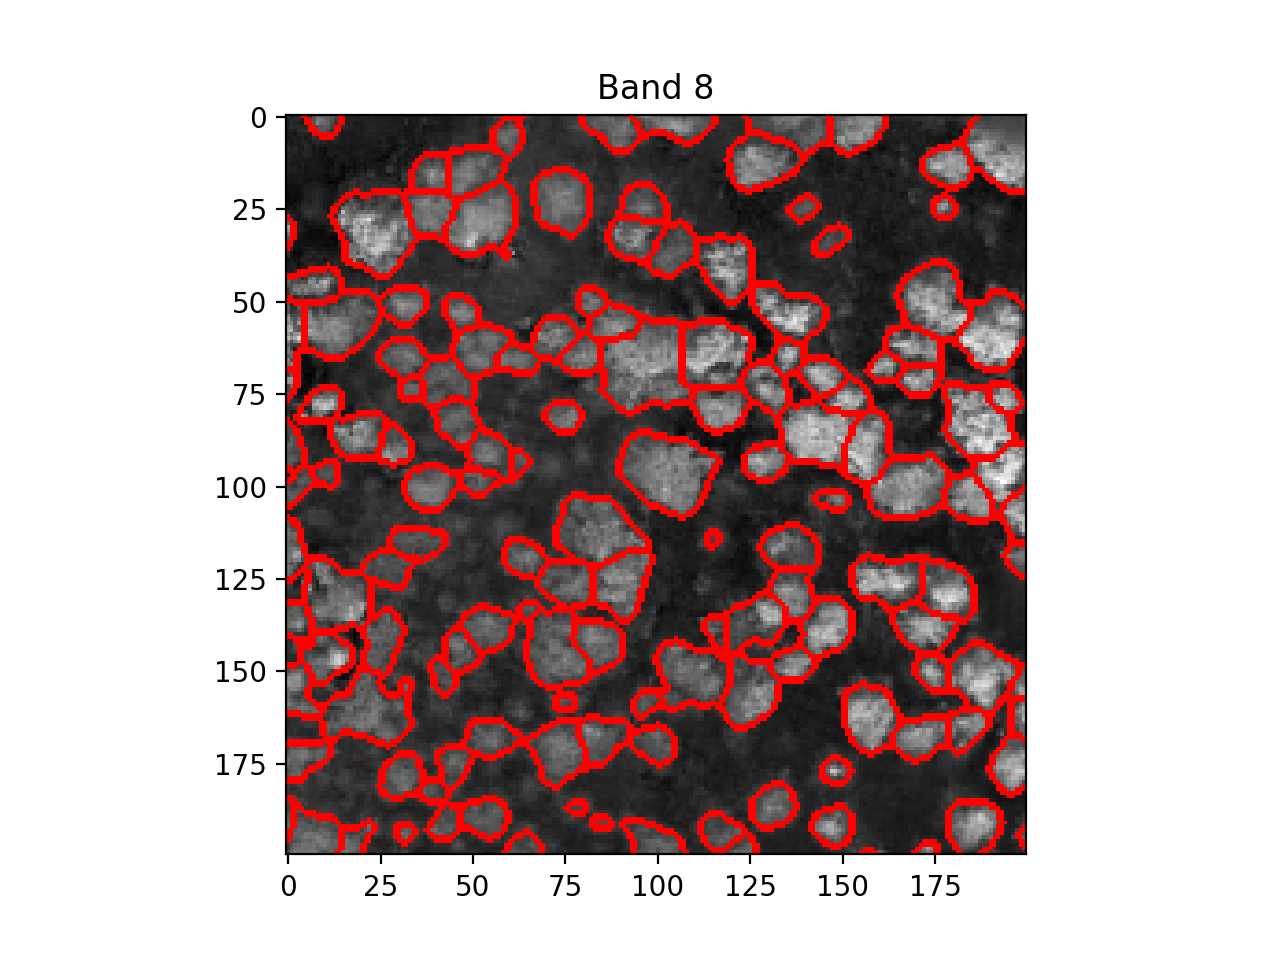

Text(0.5, 1.0, 'Band 8')

In [15]:
# Compute ITCD
crowns_tw = itcd_tw(trees_mono_n, smoothing=2, rgb=False, n_dilation=0)

# Plot
crowns_map = gray2rgb(trees_mono_n)
crowns_map[np.where(crowns_tw==True)] = (255, 0, 0)
plt.figure()
plt.imshow(crowns_map)
plt.title(f'Band {bands[i]}')

Running it on other bands.

<IPython.core.display.Javascript object>


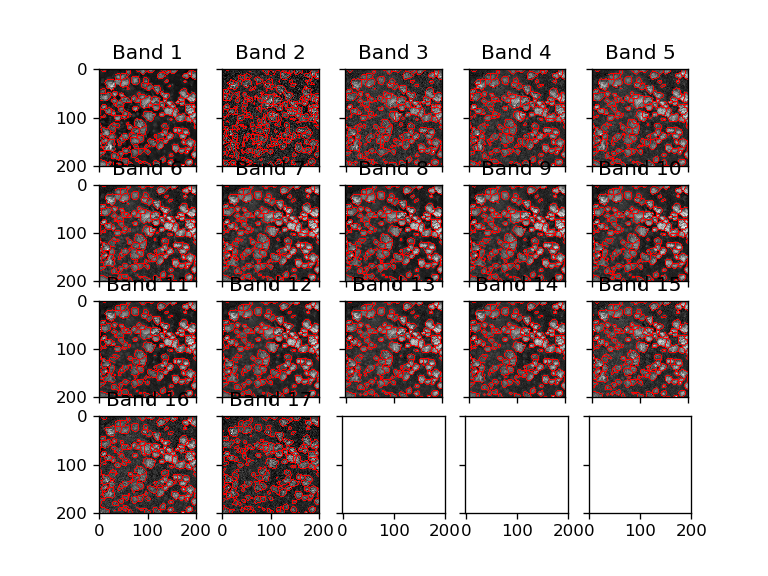

In [41]:
fig, axes = plt.subplots(4,5,sharex=True,sharey=True)

for i, trees_mono in enumerate(trees):

    # Scale image
    trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

    # Compute ITCD
    crowns_tw = itcd_tw(trees_mono_n, smoothing=2, rgb=False, n_dilation=0)

    # Plot
    crowns_map = gray2rgb(trees_mono_n)
    crowns_map[np.where(crowns_tw==True)] = (255, 0, 0)
    axes.flatten()[i].imshow(crowns_map)
    axes.flatten()[i].set_title(f'Band {bands[i]}')

### Local Maxima ITCD

In [16]:
i = 7

trees_mono = trees[i,:]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

<IPython.core.display.Javascript object>


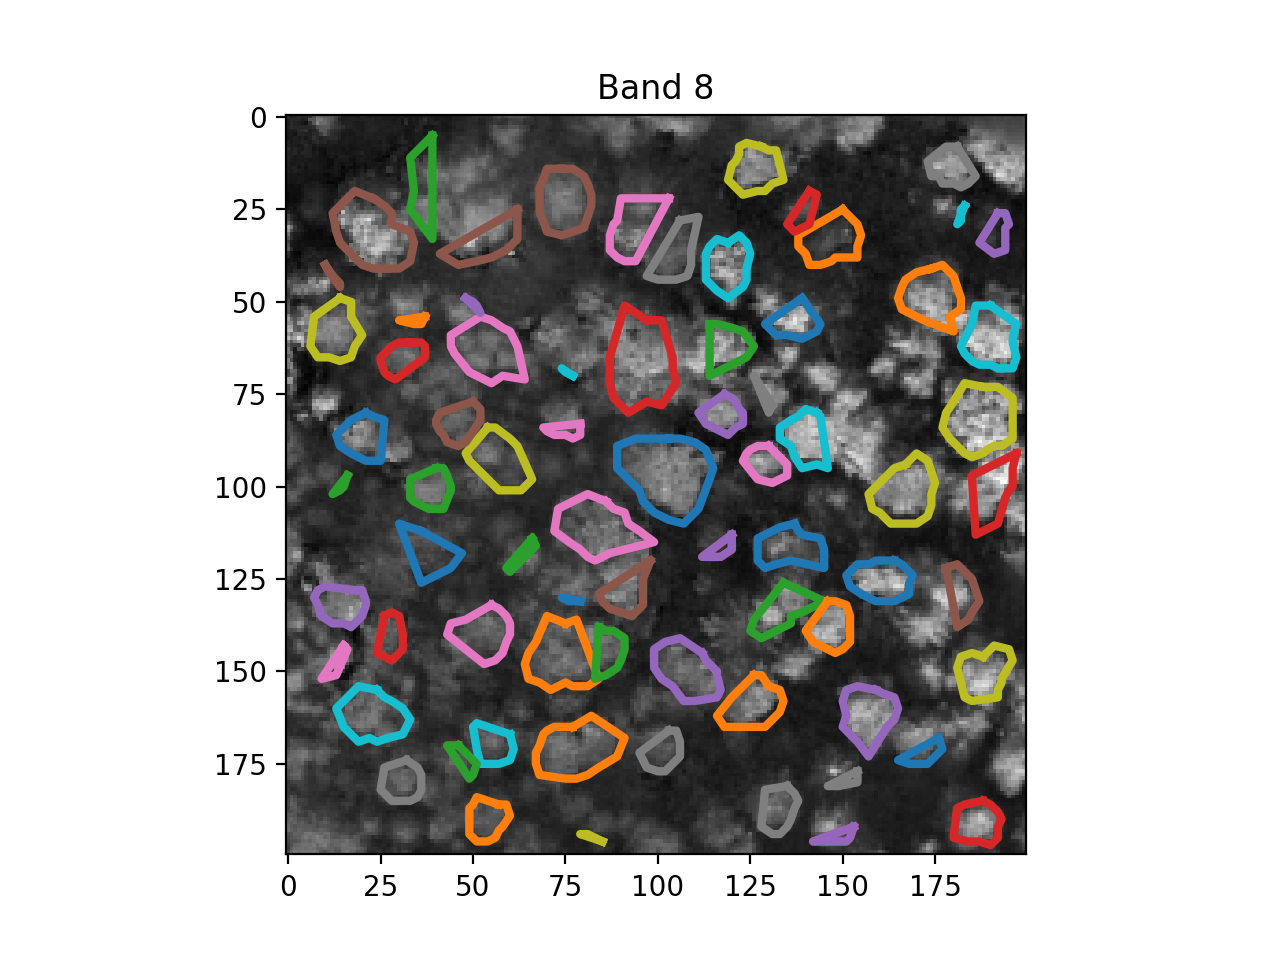

Text(0.5, 1.0, 'Band 8')

In [17]:
i = 7

trees_mono = trees[i,:]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

# Compute ITCD
crowns_lm = itcd_lm(trees_mono_n, smoothing=3, rgb=False, min_crown=5, max_crown=40, fitting=0.99, 
                    sharpness=100,
                    n_transects=16,
                    outliers=2)

# Plot
crowns_map = gray2rgb(trees_mono_n)
plt.figure()
plt.imshow(crowns_map)
for crown in crowns_lm:
    plt.plot(crown[:,0], crown[:,1], linewidth=3)
    
plt.title(f'Band {bands[i]}')

Running it on other bands.

In [34]:
fig, axes = plt.subplots(4,5,sharex=True,sharey=True)

for i, trees_mono in enumerate(trees):

    # Scale image
    trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

    # Compute ITCD
    crowns_lm = itcd_lm(trees_mono_n, smoothing=2, rgb=False, min_crown=10, max_crown=300, fitting=0.99, sharpness=100)

    # Plot
    crowns_map = gray2rgb(trees_mono_n)    
    axes.flatten()[i].imshow(crowns_map)
    for crown in crowns_lm:
        axes.flatten()[i].plot(crown[:,0], crown[:,1], linewidth=3)
    axes.flatten()[i].set_title(f'Band {bands[i]}')

<IPython.core.display.Javascript object>

/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_div

KeyboardInterrupt: 

#### Writing Results to a Shapefile

In [1]:
from to_shapefile import crowns_points, crowns_polygons

In [19]:
crowns_points('test_shape/my_shp0.shp', crowns_tw, dataset, row_shift=2090, col_shift=3080)

In [20]:
crowns_polygons('test_shape/my_shp1.shp', crowns_lm, dataset, row_shift=2090, col_shift=3080)